# Домашняя работа 1


In [1]:
# !pip install torch torchvision torchaudio torch-geometric ogb --quiet


In [2]:
from ogb.nodeproppred import NodePropPredDataset
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np



1. Загрузка данных

In [3]:
dataset = NodePropPredDataset(name='ogbn-arxiv', root='data')
graph, labels = dataset[0]

print("Количество узлов:", graph["num_nodes"])
print("Количество рёбер:", graph["edge_index"].shape[1])


Количество узлов: 169343
Количество рёбер: 1166243


In [4]:
edge_index = graph["edge_index"].T  # np.array (1.1M × 2)
G = nx.DiGraph()
G.add_edges_from(edge_index)
G = G.to_undirected()

In [ ]:
def make_connected_subgraph(G, num_nodes):
    start_node = np.random.choice(list(G.nodes))
    
    selected_nodes = set()
    queue = {start_node}

    while queue and len(selected_nodes) < num_nodes:
        current_node = queue.pop()
        if current_node not in selected_nodes:
            selected_nodes.add(current_node)
            neighbors = set(G.neighbors(current_node)) - selected_nodes
            queue.update(neighbors)

    return G.subgraph(selected_nodes).copy()

G = make_connected_subgraph(G, 30000)
print("Количество узлов в подграфе:", G.number_of_nodes())
print("Количество рёбер в подграфе:", G.number_of_edges())

Количество узлов в подграфе: 30000
Количество рёбер в подграфе: 161760


Визуализируйте граф на семпле из 1000 узлов

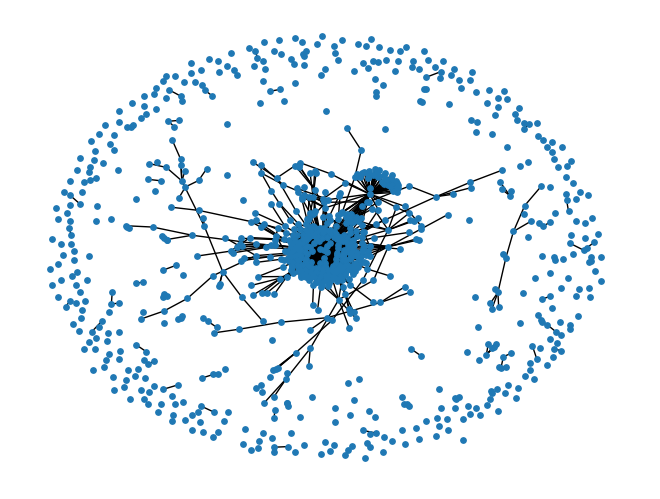

In [ ]:
sampled_nodes = list(G.nodes)[:1000:]
G_sampled = G.subgraph(sampled_nodes)
nx.draw(G_sampled, node_size=15)
plt.show()

### Предварительный анализ

Произведем предварительный анализ графа

In [ ]:
from tqdm import tqdm

def find_furthest_node(G, start_node, max_depth=None):
    visited = {start_node}

    queue_ptr = 0
    queue = [(start_node, 0)]

    while queue_ptr < len(queue):
        current_node, distance = queue[queue_ptr]
        queue_ptr += 1

        for neighbor in G.neighbors(current_node):
            if neighbor not in visited:
                if max_depth is not None and distance + 1 > max_depth:
                    return None, None
                visited.add(neighbor)
                queue.append((neighbor, distance + 1))

    return queue[-1]

def find_diameter(G):
    start_node = list(G.nodes)[0]
    furthest_node, _ = find_furthest_node(G, start_node)
    _, diameter = find_furthest_node(G, furthest_node)
    return diameter

def find_radius(G, trials=1):
    min_depth = float('inf')

    start_nodes = list(np.random.choice(list(G.nodes), size=trials, replace=False))
    
    for start_node in start_nodes:
        _, depth = find_furthest_node(G, start_node, min_depth)
        if depth is not None and depth < min_depth:
            min_depth = min(min_depth, depth)

    shuffled_nodes = list(G.nodes).copy()
    np.random.shuffle(shuffled_nodes)

    for node in tqdm(shuffled_nodes):
        _, depth = find_furthest_node(G, node, min_depth)
        if depth is not None and depth < min_depth:
            min_depth = depth

    return min_depth

In [ ]:
# TODO: средняя степень
number_of_nodes = G.number_of_nodes()
avg_degree = sum(dict(G.degree()).values()) / number_of_nodes

# TODO: плотность графа
density = 2 * G.number_of_edges() / (number_of_nodes * (number_of_nodes - 1))

# TODO: диаметер графа
diameter = find_diameter(G)

# TODO: радиус графа
radius = find_radius(G)

print(f"Средняя степень: {avg_degree:.2f}")
print(f"Плотность: {density:.6f}")
print(f"Диаметер графа: {diameter:.4f}")
print(f"Радиус графа: {radius:.4f}")

100%|██████████| 30000/30000 [32:32<00:00, 15.36it/s]

Средняя степень: 9.97
Плотность: 0.000332
Диаметер графа: 16.0000
Радиус графа: 9.0000


### Анализ на центральность

Найдите узел с максимальной центральностью

In [ ]:
# Уменьшил граф ещё в 3 раза, чтобы считать ответ не полтора часа =ъ

# TODO: Вычисление центральности по степени (degree centrality)
degree_centrality = nx.degree_centrality(G)
# print("Центральность по степени:", degree_centrality)

# TODO: Вычисление центральности по близости (closeness centrality)
closeness_centrality = nx.closeness_centrality(G) # Too long to compute
# print("Центральность по близости:", closeness_centrality)

# # TODO: Вычисление центральности по междуузловой значимости (betweenness centrality)
betweenness_centrality = nx.betweenness_centrality(G) # Too long to compute
# print("Центральность по междуузловой значимости:", betweenness_centrality)

import pandas as pd
df_cent = pd.DataFrame({'degree': degree_centrality,
                        'closeness': closeness_centrality,
                        'betweenness': betweenness_centrality}).round(3)
df_cent.loc[sorted(df_cent.index)]


,degree,closeness,betweenness
212,0.001,0.187,0.001
226,0.000,0.221,0.000
314,0.000,0.221,0.000
366,0.000,0.221,0.000
497,0.000,0.292,0.000
...,...,...,...
166495,0.001,0.142,0.001
168087,0.000,0.153,0.000
168157,0.000,0.165,0.000
168234,0.000,0.221,0.000


Анализ кластеров

In [9]:
# TODO: Вычислите средний кластерный коэффициент графа
global_cluster_coeff = nx.average_clustering(G)
print("Cредний кластерный коэффициент графа:", global_cluster_coeff)


Cредний кластерный коэффициент графа: 0.22377624849826147


In [10]:
# TODO: Вычислите коэффициент транзитивности
transitivity_coeff = nx.transitivity(G)
print("Коэффициент транзитивности графа:", transitivity_coeff)


Коэффициент транзитивности графа: 0.009238125252242768


### Поиск сообществ

Реализуйте 2 метода поиска сообществ:
1. С помощью готовой реализации в библиотеке NetworkX
2. Реализуйте самостоятельно класс с алгоритмом Clauset–Newman–Moore

Сравните полученные результаты

Алгоритм Clauset–Newman–Moore (CNM)

---

**1. Начальное состояние**
- Каждая вершина — отдельное сообщество.  
- Вычисляем степени вершин и матрицу смежности.

---

**2. Вычисляем для всех пар сообществ** $(r, s)$, между которыми есть хотя бы одно ребро:

$$
\Delta Q_{rs} = 2 \, (e_{rs} - a_r a_s)
$$

где:  

- $e_{rs}$ — доля рёбер между сообществами *r* и *s*, делённая на $2m$;  
- $a_r = \sum_t e_{rt}$ — доля концов рёбер, инцидентных *r*.

---

**2.1. Доля концов рёбер, инцидентных вершинам из $r$**

Это часть всех концов рёбер в графе, которые принадлежат вершинам, входящим в сообщество $r$.

Эта величина обозначается как $a_r$ и вычисляется по формуле:

$$
a_r = \frac{1}{2m} \sum_{i \in r} k_i
$$

где:  

- $k_i$ — степень вершины $i$ (сколько у неё рёбер);  
- $m$ — общее число рёбер в графе;  
- $2m$ — общее количество **концов рёбер** (так как каждое ребро имеет два конца).

---

**3. Выбираем пару $(r, s)$** с максимальным $\Delta Q$ и объединяем их.

---

**4. Обновляем:**
- значения $e_{rt}, a_r$;  
- новую модульность:  
  $$
  Q \leftarrow Q + \Delta Q
  $$

---

**5. Повторяем**, пока $\Delta Q > 0$.

---

**6. Выбираем состояние с максимальным $Q$** как оптимальное разбиение.


Описание алгоритма - https://arxiv.org/pdf/cond-mat/0408187

In [ ]:
class CNM:
    """
    Алгоритм Clauset–Newman–Moore для обнаружения сообществ.
    TODO: Заполните пропущенные участки кода.
    """

    def __init__(self, edges):
        self.graph = defaultdict(dict)
        for e in edges:
            if len(e) == 3:
                u, v, w = e
            else:
                u, v = e
                w = 1
            
            if u == v: continue
            self.graph[u][v] = self.graph[u].get(v, 0) + w
            self.graph[v][u] = self.graph[v].get(u, 0) + w
        self.nodes = list(self.graph.keys())
        self.m = sum(sum(self.graph[u].values()) for u in self.nodes) / 2
        self.deg = {u: sum(self.graph[u].values()) for u in self.nodes}

    def fit(self, verbose=False):
        communities = {u: {u} for u in self.nodes}
        comm_id = {u: u for u in self.nodes}
        m2 = 2 * self.m
        a = {u: self.deg[u] / m2 for u in self.nodes}

        # TODO 0: Доля рёбер между сообществами
        e = defaultdict(lambda: defaultdict(float))
        for u in self.nodes:
            for v, w in self.graph[u].items():
                if u != v:
                    e[u][v] += w
        for r in e:
            for s in e[r]:
                e[r][s] /= m2

        # Начальная модульность
        Q = -sum(a[c] ** 2 for c in a)

        # Основной цикл
        while True:
            best_dQ = 0
            best_pair = None

            # TODO 1: Найти пару (r, s) с максимальным ΔQ
            for r in e:
                for s in e[r]:
                    if r != s:
                        delta_Q = 2 * (e[r][s] - a[r] * a[s])
                        if delta_Q > best_dQ:
                            best_dQ = delta_Q
                            best_pair = (r, s)

            # TODO 2: Условие выхода
            if best_dQ <= 0:
                break

            r, s = best_pair
            if verbose:
                print(f"Объединяем {r}, {s} с ΔQ={best_dQ:.6f}")

            # TODO 3: Объединение сообществ
            communities[r].update(communities[s])
            for node in communities[s]:
                comm_id[node] = r
            del communities[s]

            # TODO 4: Обновление a, e, Q
            a[r] += a[s] - 2 * e[r][s]
            del a[s]
            for t in list(e[s].keys()):
                if t != r:
                    e[r][t] += e[s][t]
                    e[t][r] = e[r][t]
                del e[t][s]
            del e[s]
            Q += best_dQ

        final_comms = [c for c in communities.values() if c]
        return final_comms, Q


In [7]:
model = CNM(list(G.edges()))
comms, Q_my = model.fit(verbose=True)

# NetworkX эталон
nx_comms = list(greedy_modularity_communities(G))
Q_nx = modularity(G, nx_comms)

print("\n=== Сравнение ===")
print("CNM (наш)  Q =", round(Q_my, 5))
print("NetworkX    Q =", round(Q_nx, 5))
print("Количество сообществ:", len(comms))


Объединяем 133418, 154615 с ΔQ=0.000006
Объединяем 27294, 49393 с ΔQ=0.000006
Объединяем 153944, 48255 с ΔQ=0.000006
Объединяем 27104, 27391 с ΔQ=0.000006
Объединяем 33809, 37709 с ΔQ=0.000006
Объединяем 145044, 29526 с ΔQ=0.000006
Объединяем 21987, 44108 с ΔQ=0.000006
Объединяем 23621, 49834 с ΔQ=0.000006
Объединяем 30255, 32723 с ΔQ=0.000006
Объединяем 33394, 43521 с ΔQ=0.000006
Объединяем 142980, 44255 с ΔQ=0.000006
Объединяем 35426, 43458 с ΔQ=0.000006
Объединяем 17231, 46379 с ΔQ=0.000006
Объединяем 135601, 154969 с ΔQ=0.000006
Объединяем 153846, 22975 с ΔQ=0.000006
Объединяем 6712, 46145 с ΔQ=0.000006
Объединяем 39371, 39512 с ΔQ=0.000006
Объединяем 25853, 26978 с ΔQ=0.000006
Объединяем 18840, 29973 с ΔQ=0.000006
Объединяем 140019, 42192 с ΔQ=0.000006
Объединяем 13571, 35233 с ΔQ=0.000006
Объединяем 34125, 48196 с ΔQ=0.000006
Объединяем 19501, 29214 с ΔQ=0.000006
Объединяем 140523, 28542 с ΔQ=0.000006
Объединяем 4550, 146955 с ΔQ=0.000006
Объединяем 14610, 153882 с ΔQ=0.000006
Об

Мы нашли чуть более хорошее решение чем NetworkX, н почему? Всё дело в выборе best_dQ: могуn существовать рaзные пары с одним и тем же best_dQ, но в долгосрочной перспективе они будут приводить к разным Q.

Визуализация результатов

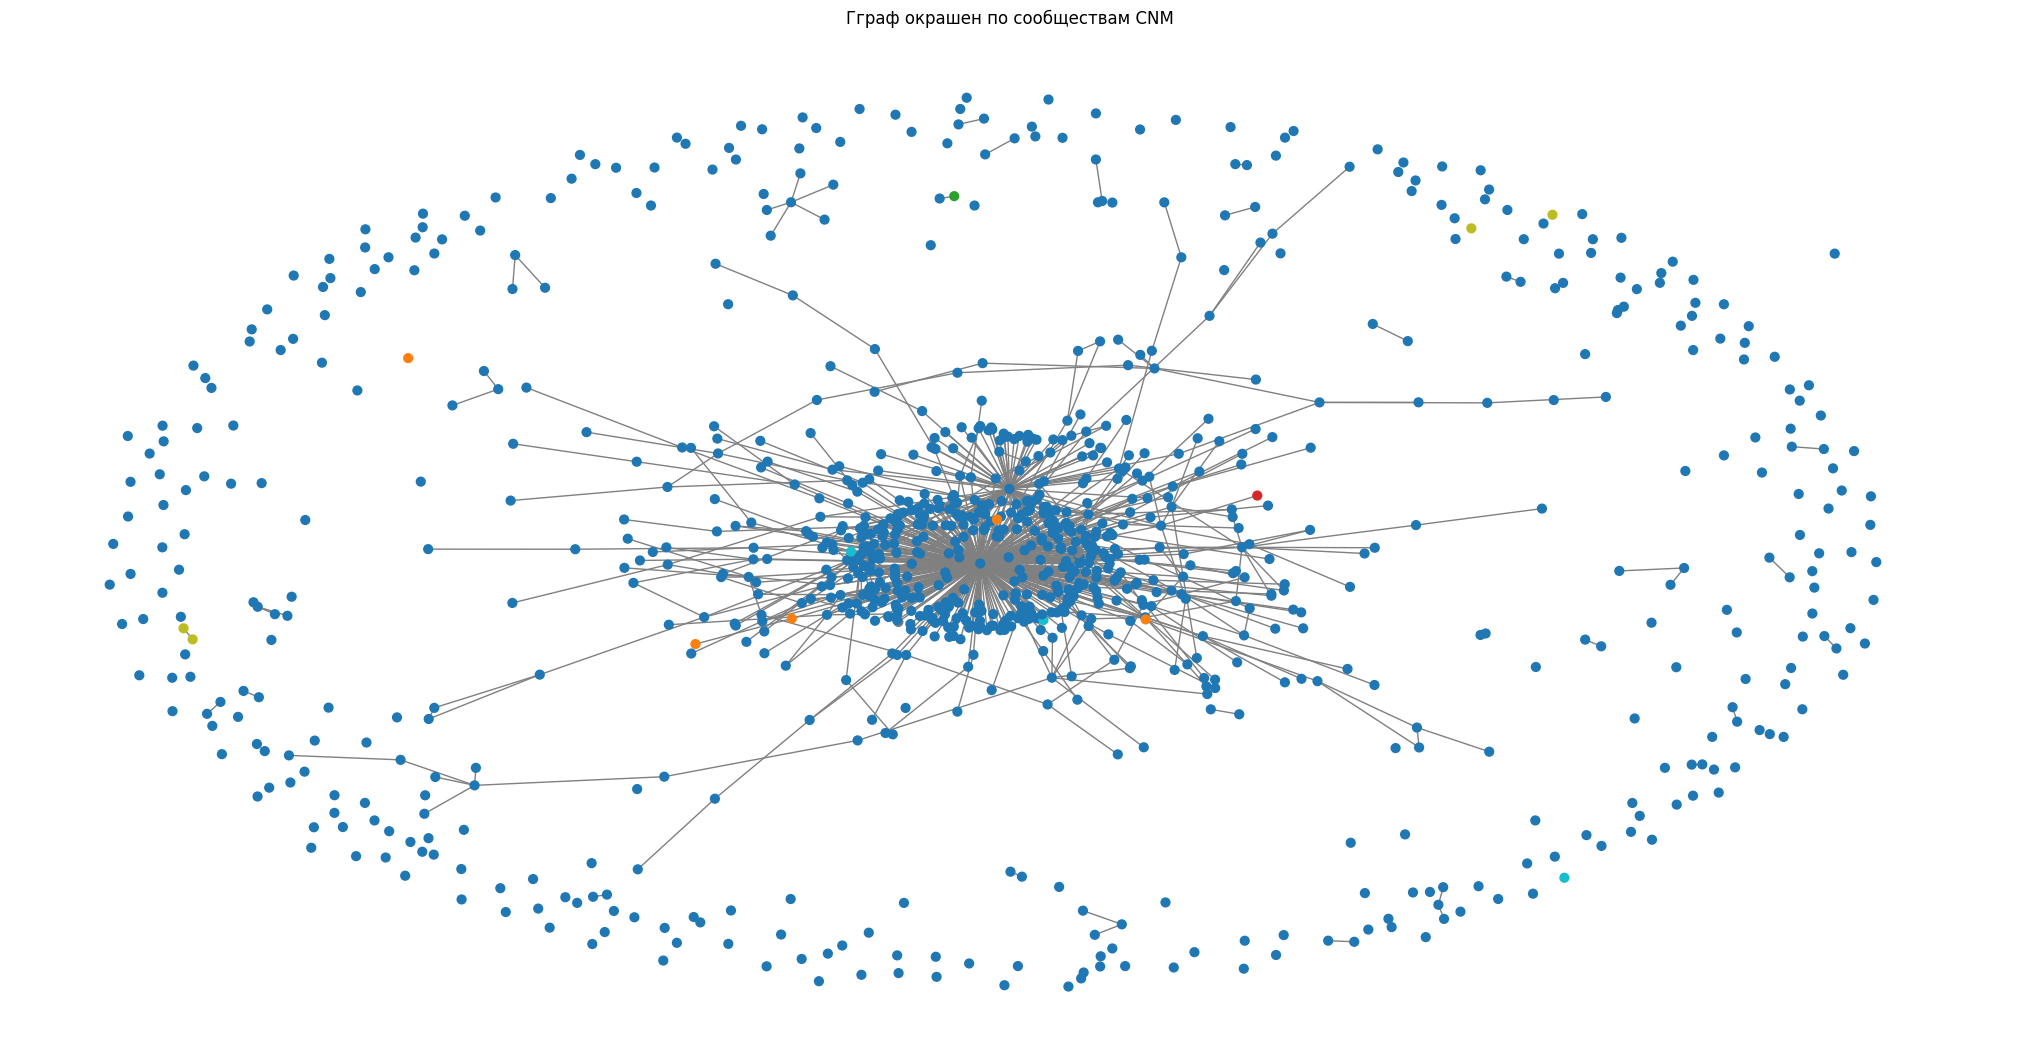

In [8]:
plt.figure(figsize=(20, 10))
sub_nodes = list(G.nodes)[:1000]
H = G.subgraph(sub_nodes)

# создаём отображение: node -> community_id
node2comm = {}
for i, comm in enumerate(nx_comms):
    for n in comm:
        node2comm[n] = i

colors = [node2comm.get(n, 0) for n in H.nodes()]
nx.draw(H, node_color=colors, node_size=40, edge_color="gray", with_labels=False, cmap="tab10")
plt.title("Гграф окрашен по сообществам CNM")
plt.show()